In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from utils_eenn_avcs import *
# from utils_notebook import get_logits_targets
from models.msdnet import MSDNet_exit
from dataloader import get_dataloaders

from laplace import Laplace
# from utils_eenn_avcs import FullLLLaplaceBridge

import random

import pickle

In [2]:
def get_logits_targets(dataset, model_folder, likelihood, epoch, cuda=True, logits_type: str = 'test'):
    assert dataset in ["cifar10", "cifar100"]
    assert logits_type in ['train', 'test', 'val']
    ARGS = parse_args()
    ARGS.data_root = "data"
    ARGS.data = dataset
    if dataset == "cifar10":
        folder_path = 'models_cifar_10'
    else:
        folder_path = 'models'
    ARGS.save = (
        # f"/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/{folder_path}/{model_folder}"
        f"/home/mona/Desktop/MSDNet-PyTorch/{folder_path}/{model_folder}"
    )
    ARGS.arch = "msdnet"
    ARGS.batch_size = 64
    ARGS.epochs = 300
    ARGS.nBlocks = 7
    ARGS.stepmode = "even"
    ARGS.base = 4
    ARGS.nChannels = 16
    ARGS.j = 16
    ARGS.num_classes = 100 if dataset == "cifar100" else 10
    ARGS.step = 2
    ARGS.use_valid = True
    ARGS.splits = ["train", "val", "test"]
    ARGS.likelihood = likelihood

    # load pre-trained model
    model = MSDNet(args=ARGS)
    model_path = f"{folder_path}/{model_folder}/save_models/checkpoint_{epoch}.pth.tar"
    if cuda:
        state = torch.load(model_path)
    else: 
        state = torch.load(model_path, map_location=torch.device('cpu'))
    params = OrderedDict()
    for params_name, params_val in state["state_dict"].items():
        params[params_name.replace("module.", "")] = params_val
        # state['state_dict'][params_name.replace('module.', '')] = state['state_dict'].pop(params_name)
    model.load_state_dict(params)
    if cuda:
        model = model.cuda()
    model.eval()

    # data
    if logits_type == 'test':
        _, _, _loader = get_dataloaders(ARGS)
    elif logits_type == 'val':
        _, _loader, _ = get_dataloaders(ARGS)
    elif logits_type == 'train':
        _loader, _, _ = get_dataloaders(ARGS)
    else:
        raise ValueError(f'logits_type={logits_type} not supported')

    logits = []
    targets = []
    with torch.no_grad():
        for i, (x, y) in enumerate(_loader):
            if cuda:
                y = y.cuda(device=None)
                x = x.cuda()

            input_var = torch.autograd.Variable(x)
            target_var = torch.autograd.Variable(y)

            output = model(input_var)
            if not isinstance(output, list):
                output = [output]

            logits.append(torch.stack(output))
            targets.append(target_var)

    logits = torch.cat(logits, dim=1).cpu()
    targets = torch.cat(targets).cpu()

    return logits, targets, ARGS

In [3]:
DATASET = 'cifar10'
# DATASET = 'cifar100'

logits, targets, ARGS = get_logits_targets(DATASET, 'models_seed_1', 'softmax', 299, cuda=True)
probs = torch.softmax(logits, dim=2)
preds = get_preds_per_exit(probs)
acc = get_acc_per_exit(preds, targets)

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [4]:
acc

[tensor(0.8977),
 tensor(0.9084),
 tensor(0.9185),
 tensor(0.9223),
 tensor(0.9227),
 tensor(0.9262),
 tensor(0.9259)]

In [5]:
L = 7

models_exit = []
for l in range(L):
    model_l, ARGS = init_model(DATASET, 'models_seed_1', 'softmax', 299, MSDNet_exit, exit=l+1, cuda=True)
    models_exit.append(model_l)

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [6]:
ARGS

Namespace(C_mono=0.0, alpha=1.0, arch='msdnet', base=4, batch_size=64, bnFactor=[1, 2, 4], bottleneck=True, clip_grad=0.0, data='cifar10', data_root='data', decay_rate=0.1, ensemble_type='DE', epochs=300, evalmode=None, evaluate_from=None, gpu=None, grFactor=[1, 2, 4], growthRate=6, image_net_train='train', image_net_val='val', j=16, likelihood='softmax', loss_type='standard', lr=0.1, lr_type='multistep', momentum=0.9, mono_penal=0.0, nBlocks=7, nChannels=16, nScales=3, num_classes=10, optimizer='sgd', precision=1000.0, pretrained_epoch='150', pretrained_model=None, print_freq=10, prod_act_func='relu', prod_eps=0.01, prod_eps_log=1e-20, prune='max', reduction=0.5, restart_lr=False, resume=False, save='/home/mona/Desktop/MSDNet-PyTorch/models_cifar_10/models_seed_1', schedule_T_end=16.0, schedule_T_start=2.0, schedule_T_type='sigmoid', seed=0, splits=['train', 'val', 'test'], start_epoch=0, step=2, stepmode='even', stop_grad=False, temp_diff=False, use_valid=True, weight_decay=0.0001, w

In [7]:
train_dataloader, _, test_dataloader = get_dataloaders(ARGS)

Files already downloaded and verified
Files already downloaded and verified
!!!!!! Load train_set_index !!!!!!


In [6]:
# LAs = []
# for l in range(L):
#     la = Laplace(models_exit[l], 'classification', subset_of_weights='last_layer', hessian_structure='full')
#     # la = FullLLLaplaceBridge(models_exit[l], 'classification')
#     la.fit(train_dataloader)

#     log_prior = torch.ones(1, requires_grad=True)
#     hyper_optimizer = torch.optim.Adam([log_prior], lr=1e-1)
#     for i in range(100):
#         hyper_optimizer.zero_grad()
#         neg_marglik = - la.log_marginal_likelihood(log_prior.exp())
#         neg_marglik.backward()
#         hyper_optimizer.step()
#         if i % 10 == 0:
#             print(f"Epoch {i} | neg_marglik: {neg_marglik.item():.4f}")
            
#     LAs.append(la)

In [ ]:
# LAs_prior_precision = [la.prior_precision.item() for la in LAs]
# pickle.dump(LAs_prior_precision, open('LAs_prior_precision.p', 'wb'))

In [8]:
# read LAs_prior_precision.p
LAs_prior_precision = pickle.load(open('LAs_prior_precision.p', 'rb'))

In [9]:
LAs = []
for l in range(L):
    print(l)
    la = Laplace(models_exit[l], 'classification', subset_of_weights='last_layer', hessian_structure='full')
    # la = FullLLLaplaceBridge(models_exit[l], 'classification')
    la.fit(train_dataloader)
    la.prior_precision = LAs_prior_precision[l]
    LAs.append(la)

0
1
2
3
4
5
6


In [10]:
pred_type='glm'
# pred_type='nn'
link_approx='mc'
# link_approx='bridge_norm'
n_samples_num=100


pred_type_denom='glm'
link_approx_denom='mc'
n_samples_denom=1

In [34]:
probs_num = []
probs_denom = []
for l in range(L):
    probs_num_l = []
    probs_denom_l = []
    targets = []
    with torch.no_grad():
        for i, (x, y) in enumerate(test_dataloader):
            
            y = y.cuda()
            x = x.cuda()

            input_var = torch.autograd.Variable(x)
            target_var = torch.autograd.Variable(y)

            output_num = LAs[l](input_var, n_samples=n_samples_num, pred_type=pred_type, link_approx=link_approx)
            output_denom = LAs[l](input_var, n_samples=n_samples_denom, pred_type=pred_type_denom, link_approx=link_approx_denom)

            probs_num_l.append(output_num)
            probs_denom_l.append(output_denom)
            targets.append(target_var)

    probs_num_l = torch.cat(probs_num_l, dim=0).cpu()
    probs_denom_l = torch.cat(probs_denom_l, dim=0).cpu()
    targets = torch.cat(targets).cpu()
    probs_num.append(probs_num_l)
    probs_denom.append(probs_denom_l)

probs_num = torch.stack(probs_num, dim=0)
probs_denom = torch.stack(probs_denom, dim=0)

In [35]:
preds = get_preds_per_exit(probs_num)
acc = get_acc_per_exit(preds, targets)
acc

[tensor(0.8966),
 tensor(0.9081),
 tensor(0.9186),
 tensor(0.9227),
 tensor(0.9231),
 tensor(0.9257),
 tensor(0.9258)]

In [43]:
# LAPLACE baseline for classification (credible sets)

alpha = 0.05
L, N, C = probs_num.shape
probs_num = probs_num.numpy()

cred_sets = []
for n in range(N):
    cred_sets_n = []
    for l in range(L):
        sorted_classes = np.argsort(probs_num[l, n])[::-1]
        cum_sum = np.cumsum(probs_num[l, n, sorted_classes])
        num_classes_to_include = np.where(cum_sum >= 1 - alpha)[0][0] + 1
        cred_sets_n.append(sorted_classes[:num_classes_to_include].tolist())
    cred_sets.append(cred_sets_n)

In [55]:
cred_sets_intersect = []
for i in range(N):
    cred_sets_intersect.append(running_intersection_classification(cred_sets[i]))

In [52]:
sizes_cred = []
coverage_cred = []
for i in range(N):
    sizes_cred.append([len(cred_sets[i][l]) for l in range(L)])
    coverage_cred.append([targets[i] in cred_sets[i][l] for l in range(L)])

consistency_cred = np.array([consistency_classifciation(cred_sets[i]) for i in range(N)])
sizes_cred = np.array(sizes_cred)
coverage_cred = np.array(coverage_cred)

In [50]:
sizes_cred.mean(axis=0)

array([1.2844, 1.2303, 1.1996, 1.1937, 1.1904, 1.1857, 1.1803])

In [51]:
coverage_cred.mean(axis=0)

array([0.9599, 0.9627, 0.9654, 0.9675, 0.9685, 0.9688, 0.9691])

In [54]:
consistency_cred.mean(axis=0)

array([1.        , 0.95567667, 0.94185262, 0.93620583, 0.9328019 ,
       0.93084833, 0.93020333])

In [56]:
sizes_cred_intersect = []
coverage_cred_intersect = []
for i in range(N):
    sizes_cred_intersect.append([len(cred_sets_intersect[i][l]) for l in range(L)])
    coverage_cred_intersect.append([targets[i] in cred_sets_intersect[i][l] for l in range(L)])

consistency_cred_intersect = np.array([consistency_classifciation(cred_sets_intersect[i]) for i in range(N)])
sizes_cred_intersect = np.array(sizes_cred_intersect)
coverage_cred_intersect = np.array(coverage_cred_intersect)

In [57]:
sizes_cred_intersect.mean(axis=0)

array([1.2844, 1.1192, 1.0591, 1.0398, 1.0285, 1.0191, 1.0144])

In [58]:
coverage_cred_intersect.mean(axis=0)

array([0.9599, 0.9455, 0.9373, 0.933 , 0.9304, 0.928 , 0.927 ])

In [59]:
consistency_cred_intersect.mean(axis=0)

array([1., 1., 1., 1., 1., 1., 1.])

In [ ]:
# torch.save((probs_num, probs_denom, targets), f"eenn_avcs_results/cifar10/nn_mc_100.pth")
# probs_num, probs_denom, targets = torch.load("eenn_avcs_results/cifar10/nn_mc_100.pth")  

# torch.save((probs_num, probs_denom, targets), f"eenn_avcs_results/cifar10/glm_mc_100.pth")
# probs_num, probs_denom, targets = torch.load("eenn_avcs_results/cifar10/glm_mc_100.pth")

In [36]:
alpha = 0.1
L, N, C = probs_num.shape

# MC
R_all = torch.div(probs_num, probs_denom).cumprod(axis=0)
C_all = []
for i in range(N):
    R_i = R_all[:, i, :].cpu().numpy()
    C_i = [list(np.where(row <= 1 / alpha)[0]) for row in R_i]
    C_all.append(running_intersection_classification(C_i))

# # Laplace Bridge
# C_all = [avcs_classification(probs_num[:, i, :].detach().numpy(), alpha=alpha, S=1) for i in range(N)]

(10000, 7)

In [ ]:
sizes = []
coverage = []
for i in range(N):
    sizes.append([len(C_all[i][l]) for l in range(L)])
    coverage.append([targets[i] in C_all[i][l] for l in range(L)])

sizes = np.array(sizes)
coverage = np.array(coverage)

In [ ]:
sizes.mean(axis=0)

array([9.409 , 8.4258, 6.4113, 5.0137, 4.2833, 3.8337, 3.5231])

In [ ]:
# _, _, conf_sets, conf_labels = raps_eenn(probs_num.cpu().numpy(), targets, alpha=alpha, disallow_zero_sets=True)
_, _, conf_sets, conf_labels = raps_eenn(probs.cpu().numpy(), targets, alpha=alpha, disallow_zero_sets=True)
conf_sets = [[list(np.where(conf_sets[l][i])[0]) for l in range(L)] for i in range(len(conf_sets[0]))]
conf_sets_intersect = [running_intersection_classification(conf_sets[i]) for i in range(len(conf_sets))]

conf_sets_sizes = np.array([[len(conf_sets[i][l]) for l in range(L)] for i in range(len(conf_sets))])
conf_sets_coverage = np.array([[conf_labels[0][i] in conf_sets[i][l] for l in range(L)] for i in range(len(conf_sets))])

conf_sets_intersect_sizes = np.array([[len(conf_sets_intersect[i][l]) for l in range(L)] for i in range(len(conf_sets_intersect))])
conf_sets_intersect_coverage = np.array([[conf_labels[0][i] in conf_sets_intersect[i][l] for l in range(L)] for i in range(len(conf_sets_intersect))])

In [ ]:
consistency_conformal = np.array([consistency_classifciation(conf_sets[i]) for i in range(len(conf_sets))])
consistency_conformal_intersect = np.array([consistency_classifciation(conf_sets_intersect[i]) for i in range(len(conf_sets_intersect))])
consistency_avcs = np.array([consistency_classifciation(C_all[i]) for i in range(N)])

In [ ]:
consistency_conformal.shape, consistency_conformal_intersect.shape, consistency_avcs.shape

((8000, 7), (8000, 7), (10000, 7))

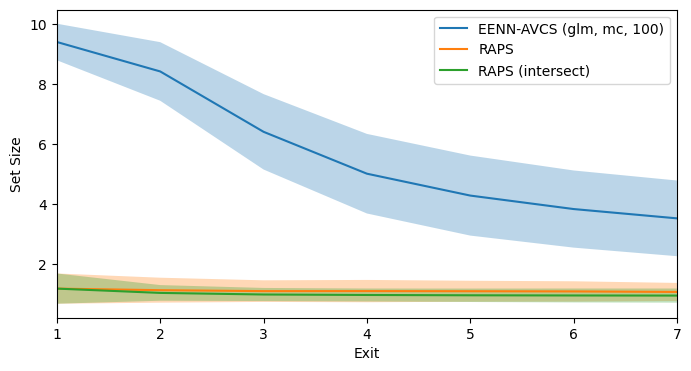

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
exits = [l + 1 for l in range(L)]

ax.plot(exits, sizes.mean(axis=0), label=f'EENN-AVCS ({pred_type}, mc, 100)')
ax.fill_between(exits, sizes.mean(axis=0) - sizes.std(axis=0), sizes.mean(axis=0) + sizes.std(axis=0), alpha=0.3)


ax.plot(exits, conf_sets_sizes.mean(axis=0), label='RAPS')
ax.fill_between(exits, conf_sets_sizes.mean(axis=0) - conf_sets_sizes.std(axis=0), conf_sets_sizes.mean(axis=0) + conf_sets_sizes.std(axis=0), alpha=0.3)

ax.plot(exits, conf_sets_intersect_sizes.mean(axis=0), label='RAPS (intersect)')
ax.fill_between(exits, conf_sets_intersect_sizes.mean(axis=0) - conf_sets_intersect_sizes.std(axis=0), conf_sets_intersect_sizes.mean(axis=0) + conf_sets_intersect_sizes.std(axis=0), alpha=0.3)

ax.set_xlabel('Exit')
ax.set_ylabel('Set Size')
ax.set_xlim([1, L])
ax.legend()

plt.show()

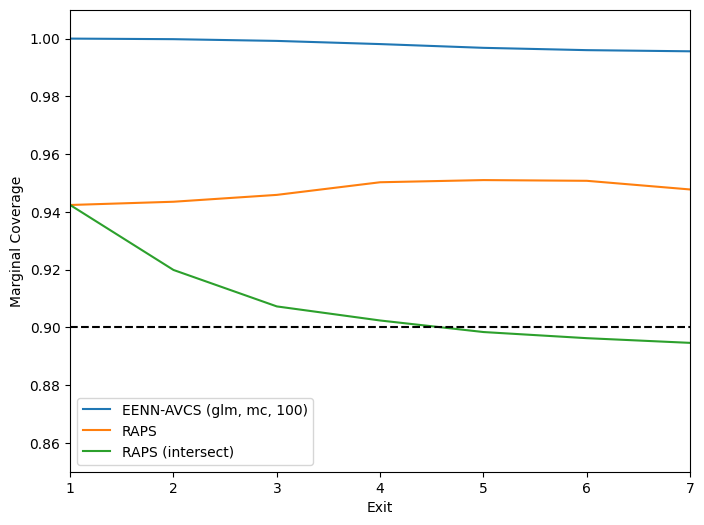

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
exits = [l + 1 for l in range(L)]


ax.plot(exits, coverage.mean(axis=0), label=f'EENN-AVCS ({pred_type}, mc, 100)')
ax.plot(exits, conf_sets_coverage.mean(axis=0), label='RAPS')
ax.plot(exits, conf_sets_intersect_coverage.mean(axis=0), label='RAPS (intersect)')

ax.axhline(y=1 - alpha, color='black', linestyle='--')

ax.set_xlabel('Exit')
ax.set_ylabel('Marginal Coverage')

ax.set_ylim([0.85, 1.01])
ax.set_xlim([1, L])
ax.legend()

plt.show()

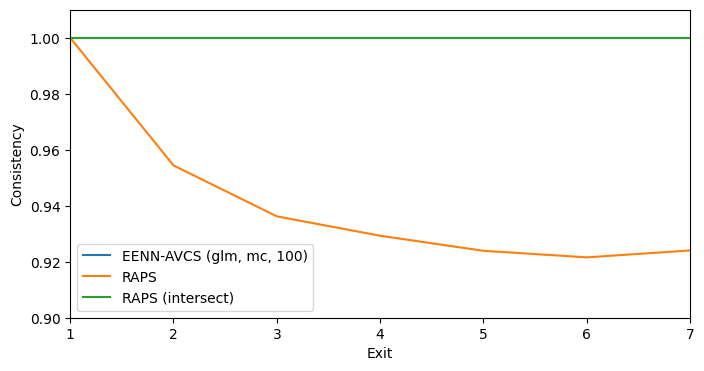

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
exits = [l + 1 for l in range(L)]

ax.plot(exits, consistency_avcs.mean(axis=0), label=f'EENN-AVCS ({pred_type}, mc, 100)')
ax.plot(exits, consistency_conformal.mean(axis=0), label='RAPS')
ax.plot(exits, consistency_conformal_intersect.mean(axis=0), label='RAPS (intersect)')

ax.set_xlabel('Exit')
ax.set_ylabel('Consistency')

ax.set_ylim([0.9, 1.01])
ax.set_xlim([1, L])
ax.legend()

plt.show()

In [ ]:
for i in range(20):
    print(consistency_conformal[i], conf_sets[i], targets[i].item())


[1. 1. 1. 1. 1. 1. 1.] [[3], [3], [3], [3], [3], [3], [3]] 3
[1. 1. 1. 1. 1. 1. 1.] [[8], [8], [8], [8], [8], [8], [8]] 8
[1. 1. 1. 1. 1. 1. 1.] [[6], [6], [6], [6], [6], [6], [6]] 8
[1. 1. 1. 1. 1. 1. 1.] [[6], [6], [6], [6], [6], [6], [6]] 0
[1. 1. 1. 1. 1. 1. 1.] [[3], [3], [3], [3], [3], [3], [3]] 6
[1. 1. 1. 1. 1. 1. 1.] [[1], [1], [1], [1], [1], [1], [1]] 6
[1. 1. 1. 1. 1. 1. 1.] [[0], [0], [0], [0], [0], [0], [0]] 1
[1. 1. 1. 1. 1. 1. 1.] [[5], [5], [5], [5], [5], [5], [5]] 6
[1. 1. 1. 1. 1. 1. 1.] [[7], [7], [7], [7], [7], [7], [7]] 3
[1. 1. 1. 1. 1. 1. 1.] [[9], [9], [9], [9], [9], [9], [9]] 1
[1.  0.5 0.5 0.  0.  0.  0. ] [[6], [6, 8], [6, 8], [8], [8], [6], [8]] 0
[1. 1. 1. 1. 1. 1. 1.] [[7], [7], [7], [7], [7], [7], [7]] 9
[1. 1. 1. 1. 1. 1. 1.] [[6], [6], [6], [6], [6], [6], [6]] 5
[1. 1. 1. 1. 1. 1. 1.] [[7], [7], [7], [7], [7], [7], [7]] 7
[1. 1. 1. 1. 1. 1. 1.] [[0], [0], [0], [0], [0], [0], [0]] 9
[1. 1. 1. 1. 1. 1. 1.] [[4], [4], [4], [4], [4], [4], [4]] 8
[1. 1. 1. 1